In [1]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import wget
import dask
import os
from tqdm import tqdm
import glob
import os

from numpy import linalg as LA
import math
import sklearn.preprocessing
import bahc
import pyRMT

%matplotlib inline

In [2]:
def eigenvalue_clipping(lambdas,v,lambda_plus):
    N=len(lambdas)
    # _s stands for _structure below
    sum_lambdas_gt_lambda_plus=np.sum(lambdas[lambdas>lambda_plus])
    sel_bulk=lambdas<=lambda_plus                     # these eigenvalues come from the seemingly random bulk
    N_bulk=np.sum(sel_bulk)
    sum_lambda_bulk=np.sum(lambdas[sel_bulk])        
    delta=sum_lambda_bulk/N_bulk                      # delta is their average, so as to conserver the trace of C
    lambdas_clean=lambdas
    lambdas_clean[lambdas_clean<=lambda_plus]=delta
    C_clean=np.zeros((N, N))
    v_m=np.matrix(v)
    for i in range(N-1):
        C_clean=C_clean+lambdas_clean[i] * np.dot(v_m[i,].T,v_m[i,]) 
    np.fill_diagonal(C_clean,1)
    return C_clean    


def solution_eig(C_asset):
    C_cov = C_asset.cov()
    l_e, V_e = LA.eig(C_cov)
    T, N = C_asset.shape
    q = N/T
    print(q)
    lambda_plus = (1+np.sqrt(q))**2
    C_clipped=eigenvalue_clipping(l_e,V_e,lambda_plus)
    return C_clipped

def weights_GVM(Sigma):
    Sigma_inv=LA.inv(Sigma)
    w_GVM=Sigma_inv.sum(axis=1)/Sigma_inv.sum()
    return w_GVM

In [3]:
all_data = pd.read_pickle("data/clean/whole_usdt_merge.pkl")
all_data = all_data.reset_index()
all_data = all_data.drop(["time"], axis=1)
log_ret_all_data = np.log(all_data).diff()
t0 = 8000
t1 = 16000
X_raw = log_ret_all_data.iloc[t0:t1].dropna(axis=1)
X_raw.shape

(8000, 253)

In [4]:
def generate_mvp_w(C_asset_in):
    # covariance matrix
    C_in_cov = C_asset_in.cov().values
    # C_out_cov = C_asset_out.cov().values

    # 1. no correlation cleaning
    w1 = weights_GVM(C_in_cov)

    # 2. eigenvalue clipping
    C_clipped_in = solution_eig(C_asset_in)
    w2 = weights_GVM(C_clipped_in)

    # 3. cleaning with bahc
    X_centered = sklearn.preprocessing.StandardScaler(with_mean=True,
                            with_std=False).fit_transform(C_asset_in.values)  # column-wise!'
    Sigma_BAHC=bahc.filterCovariance(X_centered.T)
    w3=weights_GVM(Sigma_BAHC)

    # 4. cleaning with nls
    Sigma_NLS=pyRMT.optimalShrinkage(X_centered, return_covariance=True)
    w4=weights_GVM(Sigma_NLS)

    w2 = np.asarray(w2).reshape(-1)

    return [w1, w2, w3, w4]

def get_price_return(C_asset_out, w):
    # print(C_asset_out)
    C_cum = C_asset_out.cumsum()
    # print(C_cum)
    C_w = C_cum * w
    return C_w.sum(axis=1)


In [5]:
m_list = ["no", "eig", "bahc", "nls"]
w_list = generate_mvp_w(X_raw[:500])

0.506


In [6]:
plot_in_res = pd.DataFrame()
X_no_log = all_data[X_raw.columns].diff().iloc[t0:t1]
for name, each in zip(m_list, w_list): 
    tmp = get_price_return(X_no_log[0:500], each)
    plot_in_res[name] = tmp.values
    # break

plot_out_res = pd.DataFrame()
X_no_log = all_data[X_raw.columns].diff().iloc[t0:t1]
for name, each in zip(m_list, w_list): 
    tmp = get_price_return(X_no_log[500:7500], each)
    plot_out_res[name] = tmp.values

<AxesSubplot:title={'center':'(b) Cumulative returns of out-sample'}, xlabel='Time (hour)'>

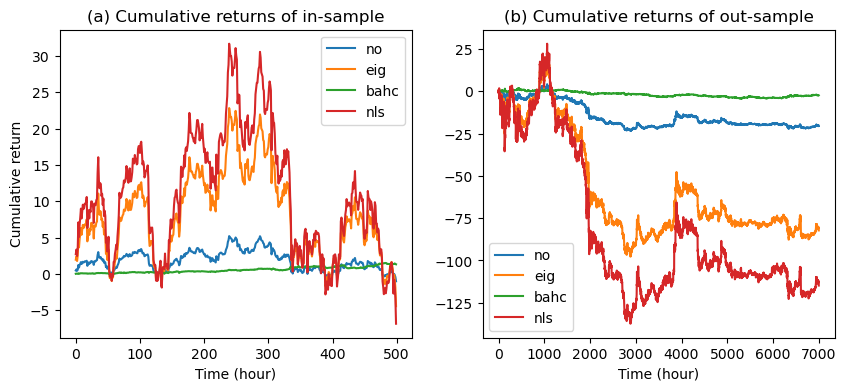

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# fig.suptitle('Cumulative returns of MVP')
ax1.set_title("(a) Cumulative returns of in-sample")
ax2.set_title("(b) Cumulative returns of out-sample")
ax1.set_xlabel("Time (hour)")
ax1.set_ylabel("Cumulative return")

ax2.set_xlabel("Time (hour)")
# ax2.set_ylabel("Cumulative return")
plot_in_res.plot(ax=ax1)
plot_out_res.plot(ax=ax2)
